In [23]:
"""
============================
Plotting NEAT Classifier
============================

An example plot of :class:`neuro_evolution._neat.NEATClassifier`
"""
import sys
import os
sys.path.append(os.getcwd()+"/Sklearn-neat")

from matplotlib import pyplot as plt
# from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from neuro_evolution import NEATClassifier
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import sys
import logging
from io import StringIO 
import re
from arg_parse import *
from sklearn.model_selection import StratifiedShuffleSplit

logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
sys.path.append(os.getcwd()+"/Sklearn-neat")

import neat
from neat import math_util
from neat.puissance import Puissance 

In [3]:
args.population_size = 5
args.fitness_limit = 0.5
args.generations = 6

In [4]:
root = logging.getLogger()
root.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [5]:
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

X = np.append(x_train,x_test).reshape(60000,32,32,3)
y = np.append(y_train,y_test).reshape(60000,1)

assert X.shape == (60000, 32, 32, 3)
assert y.shape == (60000, 1)

In [7]:
#Preprocess the data
X = X.astype('float32')
X /= 255

In [8]:
sss = StratifiedShuffleSplit(n_splits=5, 
                             train_size=args.train_size, # 900 train 
                             test_size=args.test_size, # 180 test
                             random_state=0)

for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train.shape)
print(y_train.shape)

print("---")

print(X_test.shape)
print(y_test.shape)

(12, 32, 32, 3)
(12, 1)
---
(12, 32, 32, 3)
(12, 1)


In [9]:
def find_metric_in_output(output, string):    
    result = re.findall(r"\b"+string+r" ([0-9]+\.[0-9]+)\b", str(output))
    result = np.array(result).astype('float')
    result = result[0]
    
    return result 

In [12]:
X_train_fl = X_train.reshape((X_train.shape[0], -1))
X_test_fl = X_test.reshape((X_test.shape[0], -1))

clf = NEATClassifier(number_of_generations=1,
                     fitness_threshold=args.fitness_limit,
                     pop_size=args.population_size)

results = {}
best_fitness = 0

In [14]:
# for i in range(args.generations):
#     logging.info("*** Running generation "+str(i)+" ***")
#     with Capturing() as output:
#         neat_genome = clf.fit(X_train_fl, y_train.ravel())
        
#     curr_fitness = find_metric_in_output(output, "Fitness:")
#     curr_popavgfit = find_metric_in_output(output, "Population's average fitness:")
#     curr_stdev = find_metric_in_output(output, "stdev:")
        
#     print("Fitness: {}".format(curr_fitness))
#     print("Population's average fitness: {}".format(curr_popavgfit))
#     print("Standard deviation: {}".format(curr_stdev))

#     print("---")
#     if curr_fitness > best_fitness:
#         best_fitness = curr_fitness
        
#     print("Best fitness: {}".format(best_fitness))
    
#     results[i] = {
#         "fitness":curr_fitness,
#         "pop_avg_fitness":curr_popavgfit,
#         "stdev":curr_stdev   
#     }

#     print("---\n")

In [15]:
y_pred = neat_genome.predict(X_test_fl)
    
print(classification_report(y_test.ravel(), y_pred.ravel()))

NameError: name 'neat_genome' is not defined

In [ ]:
fitness = [i['fitness'] for i in results.values()]
pop_avg_fitness = [i['pop_avg_fitness'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,args.generations,args.generations),
         fitness,
         label="Fitness")
plt.plot(np.linspace(1,args.generations,args.generations),
         pop_avg_fitness,
         label="Population's average fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend()

plt.xticks(np.linspace(1,args.generations,args.generations))

plt.savefig("../figures/fitness.png")

plt.plot()

In [ ]:
stdev = [i['stdev'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,args.generations,args.generations),
         stdev,
         label="Standard deviation")

plt.xlabel("Generation")
plt.ylabel("Standard deviation")

plt.legend()

plt.xticks(np.linspace(1,args.generations,args.generations))

plt.savefig("../figures/stdev.png")

plt.plot()

In [20]:
puissance_config = Puissance()

clf = NEATClassifier(number_of_generations=3,
                     fitness_threshold=0.5,
                     pop_size=5,
                     puissance_config = puissance_config)

In [ ]:
results = {}
best_fitness = 0

for i in range(args.generations):
    logging.info("*** Running generation "+str(i)+" ***")
    with Capturing() as output:
        %timeit neat_genome = clf.fit(X_train_fl, y_train.ravel())
        
    curr_fitness = find_metric_in_output(output, "Fitness:")
    curr_popavgfit = find_metric_in_output(output, "Population's average fitness:")
    curr_stdev = find_metric_in_output(output, "stdev:")
        
    print("Fitness: {}".format(curr_fitness))
    print("Population's average fitness: {}".format(curr_popavgfit))
    print("Standard deviation: {}".format(curr_stdev))

    print("---")
    if curr_fitness > best_fitness:
        best_fitness = curr_fitness
        
    print("Best fitness: {}".format(best_fitness))
    
    results[i] = {
        "fitness":curr_fitness,
        "pop_avg_fitness":curr_popavgfit,
        "stdev":curr_stdev   
    }

    print("---\n")

2021-06-08 15:07:39,152 - root - INFO - *** Running generation 0 ***
Fitness: 0.16666666666666666
Population's average fitness: 0.11667
Standard deviation: 0.04082
---
Best fitness: 0.16666666666666666
---

2021-06-08 15:11:24,166 - root - INFO - *** Running generation 1 ***


[]

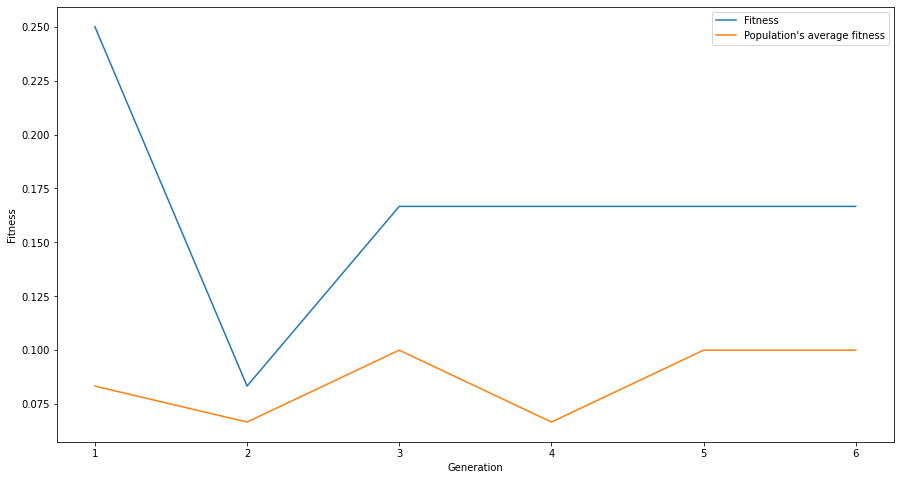

In [24]:
fitness = [i['fitness'] for i in results.values()]
pop_avg_fitness = [i['pop_avg_fitness'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,args.generations,args.generations),
         fitness,
         label="Fitness")
plt.plot(np.linspace(1,args.generations,args.generations),
         pop_avg_fitness,
         label="Population's average fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend()

plt.xticks(np.linspace(1,args.generations,args.generations))

plt.savefig("../figures/fitness.png")

plt.plot()

[]

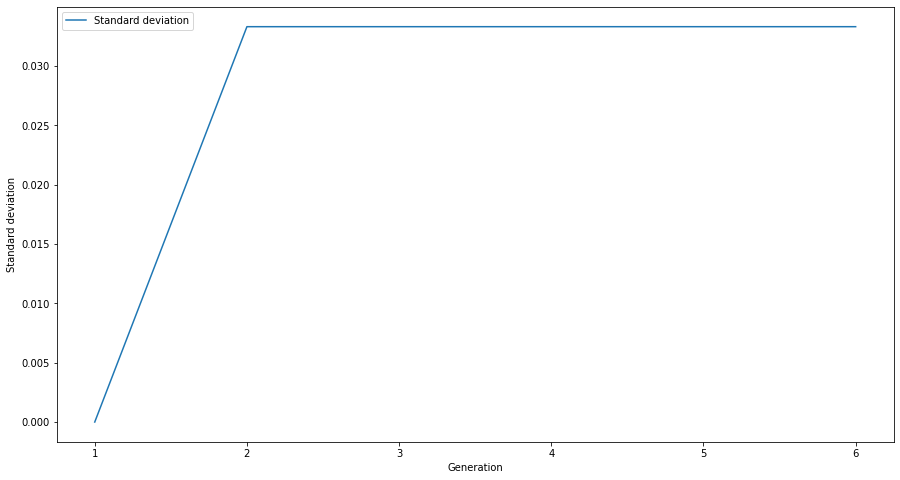

In [25]:
stdev = [i['stdev'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,args.generations,args.generations),
         stdev,
         label="Standard deviation")

plt.xlabel("Generation")
plt.ylabel("Standard deviation")

plt.legend()

plt.xticks(np.linspace(1,args.generations,args.generations))

plt.savefig("../figures/stdev.png")

plt.plot()